# Sprawozdanie z Laboratorium Projektowania i Diagnostyki Systemów Elektronicznych

Autorzy:
- Jakub Piech, 254339
- Michał Górski, 254331

***

## Analizy błędów i model SaF
W ramach laboratorium przeprowadzono analizy następujących obwodów cyfrowych w układzie scalonym DefSim2:
- NO2
- NO3
- NA2
- NA3
- NO42
- C17

Dla każdego układu wyznaczono tablicę modelu SaF, na podstawie której następnie wybrano zestaw wektorów testowych pokrywający wszystkie błędy w tym modelu. W dalszej kolejności wyznaczono pokrycie wszystkich błędów wymienionych w dokumentacji układu DefSim2 dla wybranych oraz wszystkich wektorów testowych uwzględniając także wykorzystanie testu prądowego IDDQ. 

In [2]:
import pandas as pd
from itertools import product
from typing import Iterable

pd.options.display.max_columns = 100

saf_test_vectors = dict()
"""Stores test vectors for SaF testing for a part"""
additional_IDDQ: dict[str, list[int]] = dict()
"""Stores number of faults covered by IDDQ testing for a part. Structure: [all,SaF]"""


def generate_test_vectors(n_inputs: int = 0, labels: list[str] = []):
    # labels[0] is MSB label
    if n_inputs:
        return pd.DataFrame(
            [*product(*((False, True) for _ in range(n_inputs)))],
            columns=[chr(65 + _) for _ in reversed(range(n_inputs))],
        )
    return pd.DataFrame(
        [*product(*((False, True) for _ in range(len(labels))))],
        columns=labels,
    )


def validate_checks(df: pd.DataFrame, checks: dict[str, pd.Series], out_col: str = "Q"):
    for var, check in checks.items():
        if out_col not in df.columns:
            raise ValueError(f"Output column {out_col} not in DataFrame")
        tmp = df[var].where(check)
        xored = df[out_col][tmp.notna()] ^ df[var][tmp.notna()]
        if xored.any() and not xored.all():
            raise ValueError(f"Mismatch in {var} check: {xored}")


def calc_cases(df: pd.DataFrame, checks: dict[str, pd.Series]):
    out = pd.DataFrame(index=df.index)
    for var, check in checks.items():
        tmp = df[var].where(check)
        out[f"{var}/gnd"] = tmp.where(tmp == True)
        out[f"{var}/vdd"] = tmp.where(tmp == False)
    out[out.notna()] = 1
    return out.fillna(0).T


def validate_SaF_vectors(saf_cases: pd.DataFrame, test_vectors: Iterable[int]):
    if not saf_cases.iloc[:, test_vectors].any(axis=1).all():
        raise ValueError(
            f"Test vectors {test_vectors} do not cover all checks")
    return test_vectors


# to select test cases:
# - select column with most ones and add it to test vector,
# - repeat, but skip rows, where testing is covered
# - if testing vestor is full, stop

### NO2
Tabela dla modelu SaF:

In [3]:
# NO2 circuit

df = generate_test_vectors(2)

df["Q"] = ~(df.A | df.B)

checks = {
    "A": ~df.B,
    "B": ~df.A,
    "Q": df.index >= 0,
}

validate_checks(df, checks)

out = calc_cases(df, checks)
saf_test_vectors["NO2"] = validate_SaF_vectors(out, [0, 1, 2])
out

,0,1,2,3
A/gnd,0,1,0,0
A/vdd,1,0,0,0
B/gnd,0,0,1,0
B/vdd,1,0,0,0
Q/gnd,1,0,0,0
Q/vdd,0,1,1,1


Wybrano wektory: 0, 1 i 2.

### NO3
Tabela dla modelu SaF:

In [4]:
# NO3 circuit

df = generate_test_vectors(3)

df["Q"] = ~(df.A | df.B | df.C)

checks = {
    "A": ~(df.B | df.C),
    "B": ~(df.A | df.C),
    "C": ~(df.A | df.B),
    "Q": df.index >= 0,
}

validate_checks(df, checks)

out = calc_cases(df, checks)
saf_test_vectors["NO3"] = validate_SaF_vectors(out, [0, 1, 2, 4])
# A/B short not detected by SaF and all vectors
out

,0,1,2,3,4,5,6,7
A/gnd,0,1,0,0,0,0,0,0
A/vdd,1,0,0,0,0,0,0,0
B/gnd,0,0,1,0,0,0,0,0
B/vdd,1,0,0,0,0,0,0,0
C/gnd,0,0,0,0,1,0,0,0
C/vdd,1,0,0,0,0,0,0,0
Q/gnd,1,0,0,0,0,0,0,0
Q/vdd,0,1,1,1,1,1,1,1


Wybrano wektory: 0, 1, 2 i 4.

### NA2
Tabela dla modelu SaF:

In [5]:
# NA2 circuit

df = generate_test_vectors(2)

df["Q"] = ~(df.A & df.B)

checks = {
    "A": df.B,
    "B": df.A,
    "Q": df.index >= 0,
}

validate_checks(df, checks)

out = calc_cases(df, checks)
saf_test_vectors["NA2"] = validate_SaF_vectors(out, [1, 2, 3])
# A/B shorts not detected by SaF and all vectors
additional_IDDQ["NA2"] = [1,1]
out

,0,1,2,3
A/gnd,0,0,0,1
A/vdd,0,0,1,0
B/gnd,0,0,0,1
B/vdd,0,1,0,0
Q/gnd,1,1,1,0
Q/vdd,0,0,0,1


Wybrano wektory: 1, 2 i 3.

### NA3
Tabela dla modelu SaF:

In [6]:
# NA3 circuit

df = generate_test_vectors(3)

df["Q"] = ~(df.A & df.B & df.C)

checks = {
    "A": df.B & df.C,
    "B": df.A & df.C,
    "C": df.A & df.B,
    "Q": df.index >= 0,
}

validate_checks(df, checks)

out = calc_cases(df, checks)
saf_test_vectors["NA3"] = validate_SaF_vectors(out, [3, 5, 6, 7])
# A/B, A/C, B/C shorts not detected by SaF and all vectors
additional_IDDQ["NA3"] = [3,3]
out

,0,1,2,3,4,5,6,7
A/gnd,0,0,0,0,0,0,0,1
A/vdd,0,0,0,0,0,0,1,0
B/gnd,0,0,0,0,0,0,0,1
B/vdd,0,0,0,0,0,1,0,0
C/gnd,0,0,0,0,0,0,0,1
C/vdd,0,0,0,1,0,0,0,0
Q/gnd,1,1,1,1,1,1,1,0
Q/vdd,0,0,0,0,0,0,0,1


Wybrano wektory: 3, 5, 6 i 7.

### NO42
Tabela dla modelu SaF:

In [7]:
# NO42 circuit

df = generate_test_vectors(4)

df["n3"] = ~(df.A | df.B)
df["n1"] = ~(df.D | df.C)
df["n2"] = ~(df.n1 & df.n3)

df["Q"] = ~(df.n2)

checks = {
    "A": (~df.B & df.n1),
    "B": (~df.A & df.n1),
    "C": (~df.D & df.n3),
    "D": (~df.C & df.n3),
    "n1": df.n3,
    "n2": df.index >= 0,
    "n3": df.n1,
    "Q": df.index >= 0,
}

validate_checks(df, checks)

out_no42 = calc_cases(df, checks)
saf_test_vectors["NO42"] = validate_SaF_vectors(out_no42, [0, 1, 2, 4, 8])
# n1/n3 short not detected by SaF and all vectors
# vector 1 will increase IDDQ
additional_IDDQ["NO42"] = [1, 1]
out_no42

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
A/gnd,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A/vdd,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B/gnd,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
B/vdd,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C/gnd,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
C/vdd,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D/gnd,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
D/vdd,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
n1/gnd,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
n1/vdd,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


Wybrano wektory: 0, 1, 2, 4 i 8.

### C17
Tabela dla modelu SaF:

In [8]:
# C17 circuit

df = generate_test_vectors(5)

# define/calculate intermediate signals in the structure
df["n1"] = ~(df.A & df.C)
df["n2"] = ~(df.D & df.C)
df["n3"] = ~(df.n2 & df.B)
df["n4"] = ~(df.n2 & df.E)

# define/calculate outputs
df["Y1"] = ~(df.n1 & df.n3)
df["Y2"] = ~(df.n3 & df.n4)

# define/calculate passthrough masks for signals
checks = {
    "A": (df.C & df.n3),
    "B": (df.n2 & (df.n1 | df.n4)),
    "C": (df.A & df.n3)
    | (df.D & df.B & (df.n1 | df.n4 | df.E))
    | (df.D & df.E & df.n3),
    "D": (df.C & df.B & (df.n1 | df.n4 | df.E)) | (df.C & df.E & df.n3),
    "E": (df.n2 & df.n3),
    "n1": df.n3,
    "n2": (df.B & (df.n1 | df.n4)) | (df.E & df.n3) | (df.B & df.E),
    "n3": df.n1 | df.n4,
    "n4": df.n3,
    "Y1": df.index >= 0,
    "Y2": df.index >= 0,
}

# calculate test vectors coverage for a SaF model
out_c17 = calc_cases(df, checks)
saf_test_vectors["C17"] = validate_SaF_vectors(out_c17, [4, 6, 25, 31])
# A/C, A/E, B/C, C/D, n1/n2 shorts not detected by SaF
# with vectors [4, 6, 25, 31] 3 shorts will increase IDDQ
additional_IDDQ["C17"] = [0, 3]
out_c17

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
A/gnd,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
A/vdd,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
B/gnd,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0
B/vdd,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0
C/gnd,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1
C/vdd,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0
D/gnd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
D/vdd,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0
E/gnd,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0
E/vdd,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Wybrano wektory: 4, 6, 25 i 31. Po analizie pokrycia, błędy wynikające ze zwarć pomiędzy wejściami A/C, A/E, B/C, C/D oraz sygnałami N1/N2 nie były wykrywane wybranymi wektorami. W celu sprawdzenia wpływu wykorzystania pomiaru IDDQ wyznaczono fragment tabeli prawdy układu dla testowanych wektorów:

In [9]:
df.iloc[saf_test_vectors["C17"]].astype(int)

,E,D,C,B,A,n1,n2,n3,n4,Y1,Y2
4,0,0,1,0,0,1,1,1,1,0,0
6,0,0,1,1,0,1,1,0,1,1,1
25,1,1,0,0,1,1,1,1,0,0,1
31,1,1,1,1,1,0,0,1,1,1,0


Można zauważyć, że nie wszystkie zwarcia zostaną wykryte ze względu na brak różnic w wymuszanych stanach na zwartych ze sobą sygnałach (np. dla A/E).

### Podsumowanie
Z przeprowadzonych analiz wyznaczono tabelę pokryć błędów wszystkich układów poszczególnymi zestawami testów: 

In [12]:
docs_faults_files = {
    "NO2": "NO2.csv",
    "NO3": "NO3.csv",
    "NA2": "NA2.csv",
    "NA3": "NA3.csv",
    "NO42": "NO42.csv",
    "C17": "C17.csv",
}

coverages = pd.DataFrame(
    index=["all", "all+IDDQ", "SaF", "SaF+IDDQ"],
    columns=docs_faults_files.keys(),
    dtype=float,
)
pd.options.display.float_format = "{:.1%}".format
for part, f_path in docs_faults_files.items():
    faults = pd.read_csv(f_path, sep=";", index_col=0)

    # coverage vectors:
    def calc_coverage(coverage_vector):
        cov: pd.Series = coverage_vector.any(axis=1)
        return cov[~cov], cov.mean()

    _, coverages.at["all", part] = calc_coverage(faults == 1)
    _, coverages.at["SaF", part] = calc_coverage(
        faults.iloc[:, saf_test_vectors[part]] == 1
    )
    add_all, add_saf = additional_IDDQ.get(part, [0, 0])
    coverages.at["all+IDDQ", part] = coverages.at["all", part] + \
        add_all/faults.shape[0]
    coverages.at["SaF+IDDQ", part] = coverages.at["SaF", part] + \
        add_saf/faults.shape[0]
coverages

,NO2,NO3,NA2,NA3,NO42,C17
all,100.0%,100.0%,88.9%,78.6%,97.7%,81.4%
all+IDDQ,100.0%,100.0%,100.0%,100.0%,100.0%,81.4%
SaF,100.0%,100.0%,88.9%,78.6%,97.7%,77.3%
SaF+IDDQ,100.0%,100.0%,100.0%,100.0%,100.0%,79.1%


Jak widać dla układów NO2, NO3, NA2, NA3 oraz NO42 udało się uzyskać 100-procenowe pokrycie przy wykorzystaniu modelu SaF wspieranego pomiarem prądu spoczynkowego. 

Dla układu C17 nie wszystkie błędy zostały wykryte nawet przy wykorzystaniu wszystkich wektorów testowych. Są to błędy wynikające z przerw w układzie, nie pozwalających na propagację sygnału. Wektory wyznaczone dla modelu SaF mają skuteczność zbliżoną do sprawdzenia wszystkich wektorów.

## Diagnostyka układów
Dla układów NO42 i C17 dokonano diagnozy i wyznaczono fragmenty drzew diagnostycznych dla wykrytych błędów.

### Błąd 25 w układzie NO42
Pierwsza wykryta niezgodność stanów pojawiła się dla wektora 8, który pokrywa błędy D-0, N1-1, N2-0 oraz Q-1. Aby wyłuskać informację o błędzie D-0 sprawdzono wynik dla wektora 12, który pokrywa błędy N1-1, N2-0 oraz Q-1. Nie wykryto w nim błędu, zatem diagnozą jest zwarcie wejścia D do masy układu.

Fragment drzewa diagnostycznego:

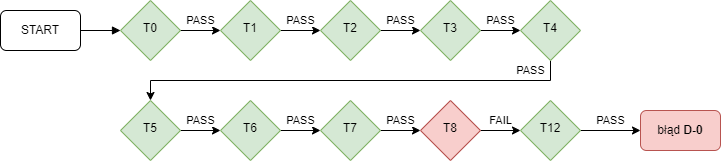

In [17]:
from IPython.display import Image, display
display(Image(filename="NO42_diag.png"))

### Błąd 17 w układzie C17
Pierwsza wykryta niezgodność stanów pojawiła się dla wektora 16, który pokrywa błędy B-1, E-0, N1-0, N3-0 oraz N4-1. Z nich tylko błędy E-0 oraz N4-1 nie były sprawdzane poprzednimi wektorami. Kolejne wektory, dla których test nie był prawidłowy również wykrywały tylko te błędy. Z pozostałych wektorów testowych nie ma takiego, który pozwoliłby sprawdzić tylko jednen z błędów, a ze względu na konstrukcję układu pomiar prądu spoczynkowego również nie pozwoli na takie sprawdzenie. Zalecane zatem jest przeprojektowanie układu w postaci wyprowadzenia sygnału E lub N4 do punktu pomiarowego w strukturze półprzewodnikowej.

Fragment drzewa diagnostycznego:

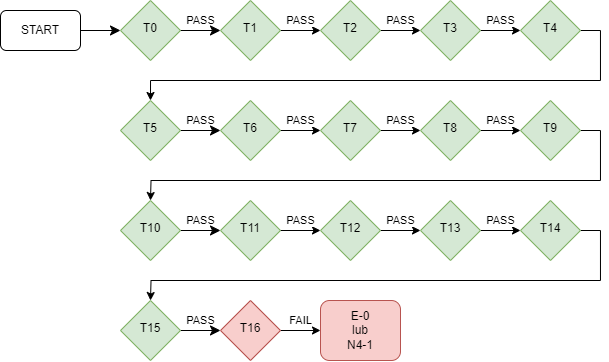

In [18]:
display(Image(filename="C17_diag.png"))